## RT-DETR Test
RT-DETR, short for "Real-Time DEtection TRansformer", is a computer vision model developed by Peking University and Baidu. In their paper, "DETRs Beat YOLOs on Real-time Object Detection" the authors claim that RT-DETR can outperform YOLO models in object detection, both in terms of speed and accuracy.

In [24]:
import os
HOME = os.getcwd()
print(HOME)

!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q git+https://github.com/roboflow/supervision.git
!pip install -q accelerate
!pip install -q roboflow
!pip install -q torchmetrics
!pip install -q "albumentations>=1.4.5"
!pip install -q supervision
!pip install -q pycocotools
!pip install pycocotools
!pip install faster-coco-eval
!pip install torchmetrics[detection]

/home/cjs/Documents/Probe-Detection-Using-Deep-Learning/notebook
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [25]:

import torch
import requests

import numpy as np
import supervision as sv
import albumentations as A

from PIL import Image
from pprint import pprint
from roboflow import Roboflow
from dataclasses import dataclass, replace
# from google.colab import userdata
from torch.utils.data import Dataset
from transformers import (
    AutoImageProcessor,
    AutoModelForObjectDetection,
    TrainingArguments,
    Trainer
)
from torchmetrics.detection.mean_ap import MeanAveragePrecision


In [26]:
# @title Load model

CHECKPOINT = "PekingU/rtdetr_r50vd_coco_o365"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForObjectDetection.from_pretrained(CHECKPOINT).to(DEVICE)
processor = AutoImageProcessor.from_pretrained(CHECKPOINT)

In [27]:
# ~~~~~~~~~~~~~~~  CONNECTION TO ROBOFLOW  ~~~~~~~~~~~~~~~
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="VBCtrUJMVNVKifV2CuOl")
project = rf.workspace("julien-xkm5o").project("probe-detection-fly")
version = project.version(1)
dataset = version.download("coco")                

Defaulting to user installation because normal site-packages is not writeable
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Probe-Detection-FLY-1 in coco:: 100%|██████████| 748/748 [00:00<00:00, 10533.36it/s]


In [28]:
ds_train = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/train",
    annotations_path=f"{dataset.location}/train/_annotations.coco.json",
)
ds_valid = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/valid",
    annotations_path=f"{dataset.location}/valid/_annotations.coco.json",
)
ds_test = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

print(f"Number of training images: {len(ds_train)}")
print(f"Number of validation images: {len(ds_valid)}")
print(f"Number of test images: {len(ds_test)}")

Number of training images: 648
Number of validation images: 61
Number of test images: 31


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBox

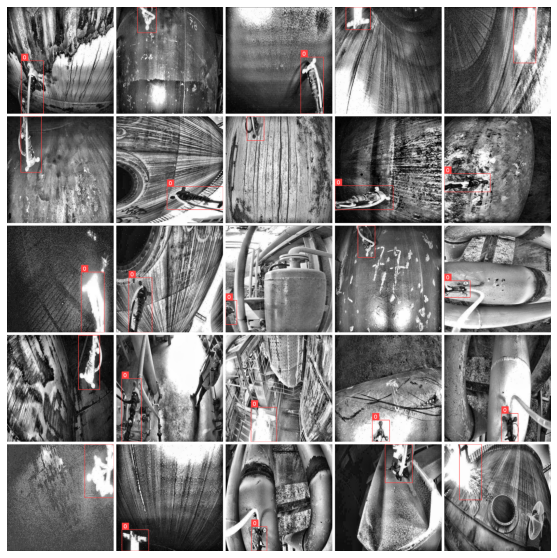

In [29]:
# @title Display dataset sample

GRID_SIZE = 5

def annotate(image, annotations, classes):
    labels = [
        classes[class_id]
        for class_id
        in annotations.class_id
    ]

    bounding_box_annotator = sv.BoundingBoxAnnotator()
    label_annotator = sv.LabelAnnotator(text_scale=1, text_thickness=2)

    annotated_image = image.copy()
    annotated_image = bounding_box_annotator.annotate(annotated_image, annotations)
    annotated_image = label_annotator.annotate(annotated_image, annotations, labels=labels)
    return annotated_image

annotated_images = []
for i in range(GRID_SIZE * GRID_SIZE):
    _, image, annotations = ds_train[i]
    annotated_image = annotate(image, annotations, ds_train.classes)
    annotated_images.append(annotated_image)

grid = sv.create_tiles(
    annotated_images,
    grid_size=(GRID_SIZE, GRID_SIZE),
    single_tile_size=(400, 400),
    tile_padding_color=sv.Color.WHITE,
    tile_margin_color=sv.Color.WHITE
)
sv.plot_image(grid, size=(10, 10))

### Preprocess the data

To finetune a model, you must preprocess the data you plan to use to match precisely the approach used for the pre-trained model. [AutoImageProcessor](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoImageProcessor) takes care of processing image data to create `pixel_values`, `pixel_mask`, and `labels` that a DETR model can train with. The image processor has some attributes that you won't have to worry about:

- `image_mean = [0.485, 0.456, 0.406 ]`
- `image_std = [0.229, 0.224, 0.225]`

These are the mean and standard deviation used to normalize images during the model pre-training. These values are crucial to replicate when doing inference or finetuning a pre-trained image model.

Instantiate the image processor from the same checkpoint as the model you want to finetune.

In [30]:
ds_train = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/train",
    annotations_path=f"{dataset.location}/train/_annotations.coco.json",
)
ds_valid = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/valid",
    annotations_path=f"{dataset.location}/valid/_annotations.coco.json",
)
ds_test = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

print(f"Number of training images: {len(ds_train)}")
print(f"Number of validation images: {len(ds_valid)}")
print(f"Number of test images: {len(ds_test)}")

Number of training images: 648
Number of validation images: 61
Number of test images: 31


In [31]:
IMAGE_SIZE = 480

processor = AutoImageProcessor.from_pretrained(
    CHECKPOINT,
    do_resize=True,
    size={"width": IMAGE_SIZE, "height": IMAGE_SIZE},
)

In [32]:
train_augmentation_and_transform = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=25
    ),
)

valid_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=1
    ),
)

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


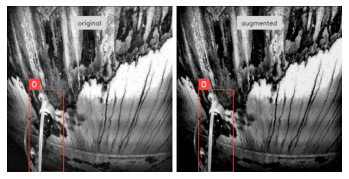

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


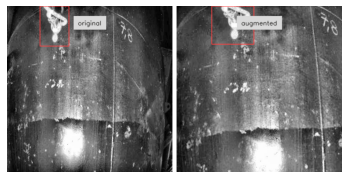

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


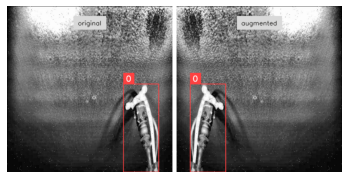

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


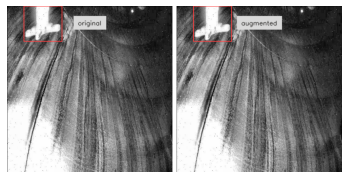

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


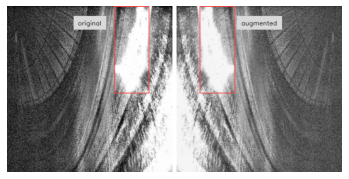

In [33]:
# @title Visualize some augmented images

IMAGE_COUNT = 5

for i in range(IMAGE_COUNT):
    _, image, annotations = ds_train[i]

    output = train_augmentation_and_transform(
        image=image,
        bboxes=annotations.xyxy,
        category=annotations.class_id
    )

    augmented_image = output["image"]
    augmented_annotations = replace(
        annotations,
        xyxy=np.array(output["bboxes"]),
        class_id=np.array(output["category"])
    )

    annotated_images = [
        annotate(image, annotations, ds_train.classes),
        annotate(augmented_image, augmented_annotations, ds_train.classes)
    ]
    grid = sv.create_tiles(
        annotated_images,
        titles=['original', 'augmented'],
        titles_scale=0.5,
        single_tile_size=(400, 400),
        tile_padding_color=sv.Color.WHITE,
        tile_margin_color=sv.Color.WHITE
    )
    sv.plot_image(grid, size=(6, 6))

In [34]:
class PyTorchDetectionDataset(Dataset):
    def __init__(self, dataset: sv.DetectionDataset, processor, transform: A.Compose = None):
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    @staticmethod
    def annotations_as_coco(image_id, categories, boxes):
        annotations = []
        for category, bbox in zip(categories, boxes):
            x1, y1, x2, y2 = bbox
            formatted_annotation = {
                "image_id": image_id,
                "category_id": category,
                "bbox": [x1, y1, x2 - x1, y2 - y1],
                "iscrowd": 0,
                "area": (x2 - x1) * (y2 - y1),
            }
            annotations.append(formatted_annotation)

        return {
            "image_id": image_id,
            "annotations": annotations,
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        _, image, annotations = self.dataset[idx]

        # Convert image to RGB numpy array
        image = image[:, :, ::-1]
        boxes = annotations.xyxy
        categories = annotations.class_id

        if self.transform:
            transformed = self.transform(
                image=image,
                bboxes=boxes,
                category=categories
            )
            image = transformed["image"]
            boxes = transformed["bboxes"]
            categories = transformed["category"]


        formatted_annotations = self.annotations_as_coco(
            image_id=idx, categories=categories, boxes=boxes)
        result = self.processor(
            images=image, annotations=formatted_annotations, return_tensors="pt")

        # Image processor expands batch dimension, lets squeeze it
        result = {k: v[0] for k, v in result.items()}

        return result

Now you can combine the image and annotation transformations to use on a batch of examples:

In [35]:
pytorch_dataset_train = PyTorchDetectionDataset(
    ds_train, processor, transform=train_augmentation_and_transform)
pytorch_dataset_valid = PyTorchDetectionDataset(
    ds_valid, processor, transform=valid_transform)
pytorch_dataset_test = PyTorchDetectionDataset(
    ds_test, processor, transform=valid_transform)

pytorch_dataset_train[15]

{'pixel_values': tensor([[[0.0745, 0.0745, 0.0745,  ..., 0.0745, 0.0745, 0.0745],
          [0.0745, 0.0745, 0.0863,  ..., 0.0745, 0.0745, 0.0745],
          [0.0784, 0.0941, 0.1765,  ..., 0.0745, 0.0745, 0.0745],
          ...,
          [0.5451, 0.6039, 0.4588,  ..., 0.0745, 0.0745, 0.0745],
          [0.5490, 0.5725, 0.3569,  ..., 0.0745, 0.0745, 0.0745],
          [0.5412, 0.5373, 0.2902,  ..., 0.0745, 0.0745, 0.0745]],
 
         [[0.0745, 0.0745, 0.0745,  ..., 0.0745, 0.0745, 0.0745],
          [0.0745, 0.0745, 0.0863,  ..., 0.0745, 0.0745, 0.0745],
          [0.0784, 0.0941, 0.1765,  ..., 0.0745, 0.0745, 0.0745],
          ...,
          [0.5451, 0.6039, 0.4588,  ..., 0.0745, 0.0745, 0.0745],
          [0.5490, 0.5725, 0.3569,  ..., 0.0745, 0.0745, 0.0745],
          [0.5412, 0.5373, 0.2902,  ..., 0.0745, 0.0745, 0.0745]],
 
         [[0.0745, 0.0745, 0.0745,  ..., 0.0745, 0.0745, 0.0745],
          [0.0745, 0.0745, 0.0863,  ..., 0.0745, 0.0745, 0.0745],
          [0.0784, 0.094

In [36]:
def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    return data

In [37]:
id2label = {id: label for id, label in enumerate(ds_train.classes)}
label2id = {label: id for id, label in enumerate(ds_train.classes)}


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


class MAPEvaluator:

    def __init__(self, image_processor, threshold=0.00, id2label=None):
        self.image_processor = image_processor
        self.threshold = threshold
        self.id2label = id2label

    def collect_image_sizes(self, targets):
        """Collect image sizes across the dataset as list of tensors with shape [batch_size, 2]."""
        image_sizes = []
        for batch in targets:
            batch_image_sizes = torch.tensor(np.array([x["size"] for x in batch]))
            image_sizes.append(batch_image_sizes)
        return image_sizes

    def collect_targets(self, targets, image_sizes):
        post_processed_targets = []
        for target_batch, image_size_batch in zip(targets, image_sizes):
            for target, (height, width) in zip(target_batch, image_size_batch):
                boxes = target["boxes"]
                boxes = sv.xcycwh_to_xyxy(boxes)
                boxes = boxes * np.array([width, height, width, height])
                boxes = torch.tensor(boxes)
                labels = torch.tensor(target["class_labels"])
                post_processed_targets.append({"boxes": boxes, "labels": labels})
        return post_processed_targets

    def collect_predictions(self, predictions, image_sizes):
        post_processed_predictions = []
        for batch, target_sizes in zip(predictions, image_sizes):
            batch_logits, batch_boxes = batch[1], batch[2]
            output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
            post_processed_output = self.image_processor.post_process_object_detection(
                output, threshold=self.threshold, target_sizes=target_sizes
            )
            post_processed_predictions.extend(post_processed_output)
        return post_processed_predictions

    @torch.no_grad()
    def __call__(self, evaluation_results):

        predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

        image_sizes = self.collect_image_sizes(targets)
        post_processed_targets = self.collect_targets(targets, image_sizes)
        post_processed_predictions = self.collect_predictions(predictions, image_sizes)

        evaluator = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
        evaluator.warn_on_many_detections = False
        evaluator.update(post_processed_predictions, post_processed_targets)

        metrics = evaluator.compute()

        # Replace list of per class metrics with separate metric for each class
        classes = metrics.pop("classes")
        map_per_class = metrics.pop("map_per_class")
        mar_100_per_class = metrics.pop("mar_100_per_class")
        for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
            class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
            metrics[f"map_{class_name}"] = class_map
            metrics[f"mar_100_{class_name}"] = class_mar

        metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

        return metrics

eval_compute_metrics_fn = MAPEvaluator(image_processor=processor, threshold=0.01, id2label=id2label)

## Training the detection model

You have done most of the heavy lifting in the previous sections, so now you are ready to train your model! The images in this dataset are still quite large, even after resizing. This means that finetuning this model will require at least one GPU.

Training involves the following steps:

- Load the model with [`AutoModelForObjectDetection`](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForObjectDetection) using the same checkpoint as in the preprocessing.
- Define your training hyperparameters in [`TrainingArguments`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments).
- Pass the training arguments to [`Trainer`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) along with the model, dataset, image processor, and data collator.
- Call [`train()`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to finetune your model.

When loading the model from the same checkpoint that you used for the preprocessing, remember to pass the `label2id` and `id2label` maps that you created earlier from the dataset's metadata. Additionally, we specify `ignore_mismatched_sizes=True` to replace the existing classification head with a new one.

In [38]:
model = AutoModelForObjectDetection.from_pretrained(
    CHECKPOINT,
    id2label=id2label,
    label2id=label2id,
    anchor_image_size=None,
    ignore_mismatched_sizes=True,
)

Some weights of RTDetrForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_r50vd_coco_o365 and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([2]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([2]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([2]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- model.

In [39]:
training_args = TrainingArguments(
    output_dir=f"{dataset.name.replace(' ', '-')}-finetune",
    num_train_epochs=20,
    max_grad_norm=0.1,
    learning_rate=5e-5,
    warmup_steps=300,
    per_device_train_batch_size=16,
    dataloader_num_workers=2,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
)

Finally, bring everything together, and call [`train()`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train):

In [40]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=pytorch_dataset_train,
    eval_dataset=pytorch_dataset_valid,
    tokenizer=processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

trainer.train()

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  5%|▌         | 41/820 [00:23<06:27,  2.01it/s]

{'eval_loss': 291.1138610839844, 'eval_map': 0.0014, 'eval_map_50': 0.0026, 'eval_map_75': 0.0022, 'eval_map_small': -1.0, 'eval_map_medium': 0.0, 'eval_map_large': 0.0132, 'eval_mar_1': 0.0098, 'eval_mar_10': 0.0131, 'eval_mar_100': 0.0492, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.0, 'eval_mar_large': 0.0577, 'eval_map_Probe-detection': -1.0, 'eval_mar_100_Probe-detection': -1.0, 'eval_map_0': 0.0014, 'eval_mar_100_0': 0.0492, 'eval_runtime': 1.9115, 'eval_samples_per_second': 31.911, 'eval_steps_per_second': 4.185, 'epoch': 1.0}


 10%|█         | 82/820 [00:48<04:58,  2.47it/s]

{'eval_loss': 50.57223129272461, 'eval_map': 0.0, 'eval_map_50': 0.0, 'eval_map_75': 0.0, 'eval_map_small': -1.0, 'eval_map_medium': 0.0, 'eval_map_large': 0.0001, 'eval_mar_1': 0.0, 'eval_mar_10': 0.0, 'eval_mar_100': 0.0148, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.0333, 'eval_mar_large': 0.0115, 'eval_map_Probe-detection': -1.0, 'eval_mar_100_Probe-detection': -1.0, 'eval_map_0': 0.0, 'eval_mar_100_0': 0.0148, 'eval_runtime': 2.5177, 'eval_samples_per_second': 24.229, 'eval_steps_per_second': 3.178, 'epoch': 2.0}


 15%|█▌        | 123/820 [01:07<04:39,  2.49it/s]

{'eval_loss': 25.41918182373047, 'eval_map': 0.0663, 'eval_map_50': 0.1015, 'eval_map_75': 0.0705, 'eval_map_small': -1.0, 'eval_map_medium': 0.0036, 'eval_map_large': 0.1093, 'eval_mar_1': 0.2574, 'eval_mar_10': 0.4475, 'eval_mar_100': 0.5852, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.2222, 'eval_mar_large': 0.6481, 'eval_map_Probe-detection': -1.0, 'eval_mar_100_Probe-detection': -1.0, 'eval_map_0': 0.0663, 'eval_mar_100_0': 0.5852, 'eval_runtime': 2.5702, 'eval_samples_per_second': 23.734, 'eval_steps_per_second': 3.113, 'epoch': 3.0}


 20%|██        | 164/820 [01:20<02:36,  4.20it/s]

{'eval_loss': 18.60004425048828, 'eval_map': 0.0665, 'eval_map_50': 0.1009, 'eval_map_75': 0.0699, 'eval_map_small': -1.0, 'eval_map_medium': 0.0107, 'eval_map_large': 0.0995, 'eval_mar_1': 0.1869, 'eval_mar_10': 0.5852, 'eval_mar_100': 0.7328, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.5222, 'eval_mar_large': 0.7692, 'eval_map_Probe-detection': -1.0, 'eval_mar_100_Probe-detection': -1.0, 'eval_map_0': 0.0665, 'eval_mar_100_0': 0.7328, 'eval_runtime': 0.9455, 'eval_samples_per_second': 64.519, 'eval_steps_per_second': 8.461, 'epoch': 4.0}


 25%|██▌       | 205/820 [01:32<02:24,  4.24it/s]

{'eval_loss': 12.252199172973633, 'eval_map': 0.1482, 'eval_map_50': 0.2029, 'eval_map_75': 0.1638, 'eval_map_small': -1.0, 'eval_map_medium': 0.0545, 'eval_map_large': 0.1847, 'eval_mar_1': 0.4918, 'eval_mar_10': 0.8016, 'eval_mar_100': 0.877, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.7778, 'eval_mar_large': 0.8942, 'eval_map_Probe-detection': -1.0, 'eval_mar_100_Probe-detection': -1.0, 'eval_map_0': 0.1482, 'eval_mar_100_0': 0.877, 'eval_runtime': 1.0474, 'eval_samples_per_second': 58.238, 'eval_steps_per_second': 7.638, 'epoch': 5.0}


 30%|███       | 246/820 [01:45<02:15,  4.23it/s]

{'eval_loss': 12.23852825164795, 'eval_map': 0.1917, 'eval_map_50': 0.2429, 'eval_map_75': 0.2131, 'eval_map_small': -1.0, 'eval_map_medium': 0.0511, 'eval_map_large': 0.2658, 'eval_mar_1': 0.423, 'eval_mar_10': 0.8, 'eval_mar_100': 0.8787, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8111, 'eval_mar_large': 0.8904, 'eval_map_Probe-detection': -1.0, 'eval_mar_100_Probe-detection': -1.0, 'eval_map_0': 0.1917, 'eval_mar_100_0': 0.8787, 'eval_runtime': 0.937, 'eval_samples_per_second': 65.104, 'eval_steps_per_second': 8.538, 'epoch': 6.0}


 35%|███▌      | 287/820 [01:57<02:04,  4.27it/s]

{'eval_loss': 11.371892929077148, 'eval_map': 0.127, 'eval_map_50': 0.1612, 'eval_map_75': 0.141, 'eval_map_small': -1.0, 'eval_map_medium': 0.157, 'eval_map_large': 0.1438, 'eval_mar_1': 0.4016, 'eval_mar_10': 0.7295, 'eval_mar_100': 0.8459, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.7111, 'eval_mar_large': 0.8692, 'eval_map_Probe-detection': -1.0, 'eval_mar_100_Probe-detection': -1.0, 'eval_map_0': 0.127, 'eval_mar_100_0': 0.8459, 'eval_runtime': 0.9584, 'eval_samples_per_second': 63.651, 'eval_steps_per_second': 8.348, 'epoch': 7.0}


 40%|████      | 328/820 [02:10<01:57,  4.18it/s]

{'eval_loss': 10.677058219909668, 'eval_map': 0.1464, 'eval_map_50': 0.2025, 'eval_map_75': 0.1571, 'eval_map_small': -1.0, 'eval_map_medium': 0.0592, 'eval_map_large': 0.1923, 'eval_mar_1': 0.3328, 'eval_mar_10': 0.7164, 'eval_mar_100': 0.8803, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8222, 'eval_mar_large': 0.8904, 'eval_map_Probe-detection': -1.0, 'eval_mar_100_Probe-detection': -1.0, 'eval_map_0': 0.1464, 'eval_mar_100_0': 0.8803, 'eval_runtime': 1.0505, 'eval_samples_per_second': 58.068, 'eval_steps_per_second': 7.616, 'epoch': 8.0}


 45%|████▌     | 369/820 [02:22<01:45,  4.28it/s]

{'eval_loss': 9.63294792175293, 'eval_map': 0.054, 'eval_map_50': 0.0773, 'eval_map_75': 0.0571, 'eval_map_small': -1.0, 'eval_map_medium': 0.029, 'eval_map_large': 0.0654, 'eval_mar_1': 0.2049, 'eval_mar_10': 0.4869, 'eval_mar_100': 0.8443, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.7556, 'eval_mar_large': 0.8596, 'eval_map_Probe-detection': -1.0, 'eval_mar_100_Probe-detection': -1.0, 'eval_map_0': 0.054, 'eval_mar_100_0': 0.8443, 'eval_runtime': 1.0555, 'eval_samples_per_second': 57.79, 'eval_steps_per_second': 7.579, 'epoch': 9.0}


 50%|█████     | 410/820 [02:34<01:36,  4.25it/s]

{'eval_loss': 9.263466835021973, 'eval_map': 0.3795, 'eval_map_50': 0.4631, 'eval_map_75': 0.4182, 'eval_map_small': -1.0, 'eval_map_medium': 0.1296, 'eval_map_large': 0.4341, 'eval_mar_1': 0.4934, 'eval_mar_10': 0.7934, 'eval_mar_100': 0.8672, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8111, 'eval_mar_large': 0.8769, 'eval_map_Probe-detection': -1.0, 'eval_mar_100_Probe-detection': -1.0, 'eval_map_0': 0.3795, 'eval_mar_100_0': 0.8672, 'eval_runtime': 0.925, 'eval_samples_per_second': 65.948, 'eval_steps_per_second': 8.649, 'epoch': 10.0}


 55%|█████▌    | 451/820 [02:46<01:24,  4.35it/s]

{'eval_loss': 9.656810760498047, 'eval_map': 0.0863, 'eval_map_50': 0.1439, 'eval_map_75': 0.0936, 'eval_map_small': -1.0, 'eval_map_medium': 0.0827, 'eval_map_large': 0.0994, 'eval_mar_1': 0.2852, 'eval_mar_10': 0.6393, 'eval_mar_100': 0.8492, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.8, 'eval_mar_large': 0.8577, 'eval_map_Probe-detection': -1.0, 'eval_mar_100_Probe-detection': -1.0, 'eval_map_0': 0.0863, 'eval_mar_100_0': 0.8492, 'eval_runtime': 1.057, 'eval_samples_per_second': 57.712, 'eval_steps_per_second': 7.569, 'epoch': 11.0}


 60%|██████    | 492/820 [02:58<01:15,  4.34it/s]

{'eval_loss': 8.994730949401855, 'eval_map': 0.0584, 'eval_map_50': 0.0941, 'eval_map_75': 0.068, 'eval_map_small': -1.0, 'eval_map_medium': 0.0231, 'eval_map_large': 0.0731, 'eval_mar_1': 0.1787, 'eval_mar_10': 0.5934, 'eval_mar_100': 0.8541, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.7778, 'eval_mar_large': 0.8673, 'eval_map_Probe-detection': -1.0, 'eval_mar_100_Probe-detection': -1.0, 'eval_map_0': 0.0584, 'eval_mar_100_0': 0.8541, 'eval_runtime': 0.9123, 'eval_samples_per_second': 66.866, 'eval_steps_per_second': 8.769, 'epoch': 12.0}


 61%|██████    | 500/820 [03:01<01:37,  3.27it/s]

{'loss': 56.6605, 'grad_norm': 33.88808822631836, 'learning_rate': 3.0769230769230774e-05, 'epoch': 12.2}


 65%|██████▌   | 533/820 [03:10<01:05,  4.35it/s]

{'eval_loss': 9.00377082824707, 'eval_map': 0.0601, 'eval_map_50': 0.0895, 'eval_map_75': 0.0643, 'eval_map_small': -1.0, 'eval_map_medium': 0.0151, 'eval_map_large': 0.0795, 'eval_mar_1': 0.1951, 'eval_mar_10': 0.5459, 'eval_mar_100': 0.8459, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.7444, 'eval_mar_large': 0.8635, 'eval_map_Probe-detection': -1.0, 'eval_mar_100_Probe-detection': -1.0, 'eval_map_0': 0.0601, 'eval_mar_100_0': 0.8459, 'eval_runtime': 0.9019, 'eval_samples_per_second': 67.638, 'eval_steps_per_second': 8.871, 'epoch': 13.0}


 70%|███████   | 574/820 [03:23<00:57,  4.30it/s]

{'eval_loss': 8.64738655090332, 'eval_map': 0.074, 'eval_map_50': 0.1144, 'eval_map_75': 0.0724, 'eval_map_small': -1.0, 'eval_map_medium': 0.0195, 'eval_map_large': 0.1055, 'eval_mar_1': 0.2066, 'eval_mar_10': 0.6148, 'eval_mar_100': 0.8328, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.7333, 'eval_mar_large': 0.85, 'eval_map_Probe-detection': -1.0, 'eval_mar_100_Probe-detection': -1.0, 'eval_map_0': 0.074, 'eval_mar_100_0': 0.8328, 'eval_runtime': 1.0507, 'eval_samples_per_second': 58.054, 'eval_steps_per_second': 7.614, 'epoch': 14.0}


 75%|███████▌  | 615/820 [03:37<01:03,  3.22it/s]

{'eval_loss': 9.71957015991211, 'eval_map': 0.0644, 'eval_map_50': 0.1005, 'eval_map_75': 0.0662, 'eval_map_small': -1.0, 'eval_map_medium': 0.0085, 'eval_map_large': 0.0992, 'eval_mar_1': 0.1885, 'eval_mar_10': 0.5377, 'eval_mar_100': 0.7934, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.7556, 'eval_mar_large': 0.8, 'eval_map_Probe-detection': -1.0, 'eval_mar_100_Probe-detection': -1.0, 'eval_map_0': 0.0644, 'eval_mar_100_0': 0.7934, 'eval_runtime': 2.4128, 'eval_samples_per_second': 25.282, 'eval_steps_per_second': 3.316, 'epoch': 15.0}


 80%|████████  | 656/820 [04:01<01:21,  2.00it/s]

{'eval_loss': 9.177383422851562, 'eval_map': 0.0419, 'eval_map_50': 0.0712, 'eval_map_75': 0.0383, 'eval_map_small': -1.0, 'eval_map_medium': 0.0233, 'eval_map_large': 0.0516, 'eval_mar_1': 0.1443, 'eval_mar_10': 0.4869, 'eval_mar_100': 0.8033, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.7778, 'eval_mar_large': 0.8077, 'eval_map_Probe-detection': -1.0, 'eval_mar_100_Probe-detection': -1.0, 'eval_map_0': 0.0419, 'eval_mar_100_0': 0.8033, 'eval_runtime': 2.4721, 'eval_samples_per_second': 24.676, 'eval_steps_per_second': 3.236, 'epoch': 16.0}


 85%|████████▌ | 697/820 [04:26<00:47,  2.60it/s]

{'eval_loss': 9.022994041442871, 'eval_map': 0.0319, 'eval_map_50': 0.0503, 'eval_map_75': 0.0356, 'eval_map_small': -1.0, 'eval_map_medium': 0.0127, 'eval_map_large': 0.0423, 'eval_mar_1': 0.1295, 'eval_mar_10': 0.4197, 'eval_mar_100': 0.8098, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.6778, 'eval_mar_large': 0.8327, 'eval_map_Probe-detection': -1.0, 'eval_mar_100_Probe-detection': -1.0, 'eval_map_0': 0.0319, 'eval_mar_100_0': 0.8098, 'eval_runtime': 2.5079, 'eval_samples_per_second': 24.323, 'eval_steps_per_second': 3.19, 'epoch': 17.0}


 90%|█████████ | 738/820 [04:50<00:40,  2.04it/s]

{'eval_loss': 9.017204284667969, 'eval_map': 0.0363, 'eval_map_50': 0.0607, 'eval_map_75': 0.0328, 'eval_map_small': -1.0, 'eval_map_medium': 0.0077, 'eval_map_large': 0.0529, 'eval_mar_1': 0.0967, 'eval_mar_10': 0.4459, 'eval_mar_100': 0.818, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.7333, 'eval_mar_large': 0.8327, 'eval_map_Probe-detection': -1.0, 'eval_mar_100_Probe-detection': -1.0, 'eval_map_0': 0.0363, 'eval_mar_100_0': 0.818, 'eval_runtime': 1.9788, 'eval_samples_per_second': 30.826, 'eval_steps_per_second': 4.043, 'epoch': 18.0}


 95%|█████████▌| 779/820 [05:14<00:16,  2.48it/s]

{'eval_loss': 9.032943725585938, 'eval_map': 0.0326, 'eval_map_50': 0.0531, 'eval_map_75': 0.0365, 'eval_map_small': -1.0, 'eval_map_medium': 0.0333, 'eval_map_large': 0.0393, 'eval_mar_1': 0.0934, 'eval_mar_10': 0.4508, 'eval_mar_100': 0.7852, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.7222, 'eval_mar_large': 0.7962, 'eval_map_Probe-detection': -1.0, 'eval_mar_100_Probe-detection': -1.0, 'eval_map_0': 0.0326, 'eval_mar_100_0': 0.7852, 'eval_runtime': 2.5068, 'eval_samples_per_second': 24.334, 'eval_steps_per_second': 3.191, 'epoch': 19.0}


100%|██████████| 820/820 [05:38<00:00,  2.11it/s]

{'eval_loss': 8.916924476623535, 'eval_map': 0.0359, 'eval_map_50': 0.0576, 'eval_map_75': 0.0378, 'eval_map_small': -1.0, 'eval_map_medium': 0.0206, 'eval_map_large': 0.0457, 'eval_mar_1': 0.1328, 'eval_mar_10': 0.4164, 'eval_mar_100': 0.7492, 'eval_mar_small': -1.0, 'eval_mar_medium': 0.6, 'eval_mar_large': 0.775, 'eval_map_Probe-detection': -1.0, 'eval_mar_100_Probe-detection': -1.0, 'eval_map_0': 0.0359, 'eval_mar_100_0': 0.7492, 'eval_runtime': 2.5957, 'eval_samples_per_second': 23.5, 'eval_steps_per_second': 3.082, 'epoch': 20.0}


There were missing keys in the checkpoint model loaded: ['class_embed.0.weight', 'class_embed.0.bias', 'class_embed.1.weight', 'class_embed.1.bias', 'class_embed.2.weight', 'class_embed.2.bias', 'class_embed.3.weight', 'class_embed.3.bias', 'class_embed.4.weight', 'class_embed.4.bias', 'class_embed.5.weight', 'class_embed.5.bias', 'bbox_embed.0.layers.0.weight', 'bbox_embed.0.layers.0.bias', 'bbox_embed.0.layers.1.weight', 'bbox_embed.0.layers.1.bias', 'bbox_embed.0.layers.2.weight', 'bbox_embed.0.layers.2.bias', 'bbox_embed.1.layers.0.weight', 'bbox_embed.1.layers.0.bias', 'bbox_embed.1.layers.1.weight', 'bbox_embed.1.layers.1.bias', 'bbox_embed.1.layers.2.weight', 'bbox_embed.1.layers.2.bias', 'bbox_embed.2.layers.0.weight', 'bbox_embed.2.layers.0.bias', 'bbox_embed.2.layers.1.weight', 'bbox_embed.2.layers.1.bias', 'bbox_embed.2.layers.2.weight', 'bbox_embed.2.layers.2.bias', 'bbox_embed.3.layers.0.weight', 'bbox_embed.3.layers.0.bias', 'bbox_embed.3.layers.1.weight', 'bbox_embed.3.l

{'train_runtime': 339.2907, 'train_samples_per_second': 38.197, 'train_steps_per_second': 2.417, 'train_loss': 36.57616979087271, 'epoch': 20.0}


TrainOutput(global_step=820, training_loss=36.57616979087271, metrics={'train_runtime': 339.2907, 'train_samples_per_second': 38.197, 'train_steps_per_second': 2.417, 'total_flos': 2.296656610541568e+18, 'train_loss': 36.57616979087271, 'epoch': 20.0})

## Evaluate

In [41]:
# @title Collect predictions

targets = []
predictions = []

for i in range(len(ds_test)):
    path, sourece_image, annotations = ds_test[i]

    image = Image.open(path)
    inputs = processor(image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)

    w, h = image.size
    results = processor.post_process_object_detection(
        outputs, target_sizes=[(h, w)], threshold=0.3)

    detections = sv.Detections.from_transformers(results[0])

    targets.append(annotations)
    predictions.append(detections)

In [42]:
# @title Calculate mAP
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.49
map50: 0.52
map75: 0.52


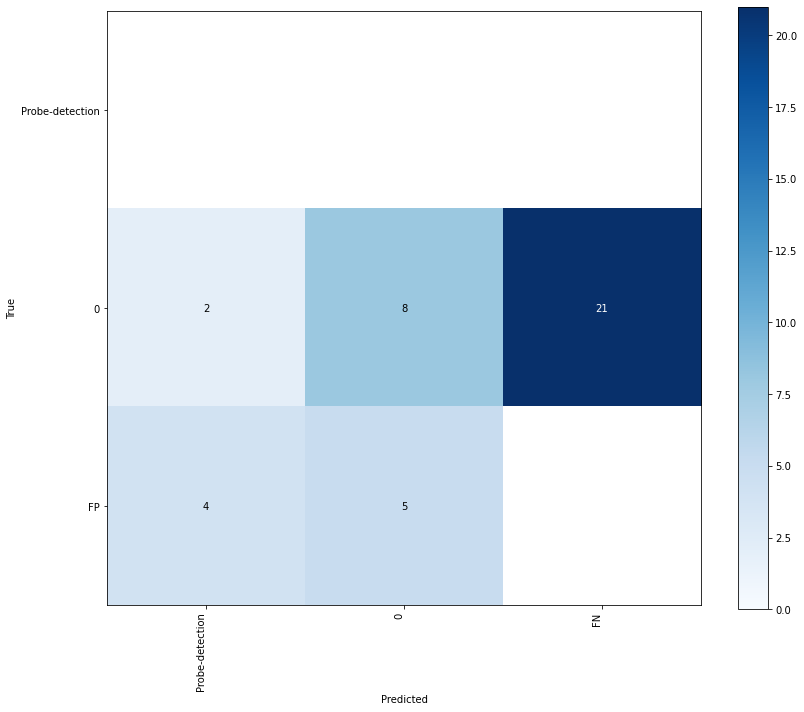

In [43]:
# @title Calculate Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=ds_test.classes
)

_ = confusion_matrix.plot()

## Save fine-tuned model on hard drive

In [44]:
# model.save_pretrained("/content/rt-detr/")
# processor.save_pretrained("/content/rt-detr/")

PermissionError: [Errno 13] Permission denied: '/content'

## Inference with fine-tuned RT-DETR model

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


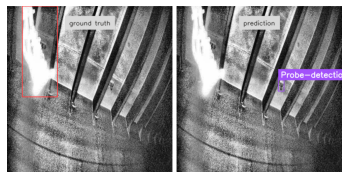

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


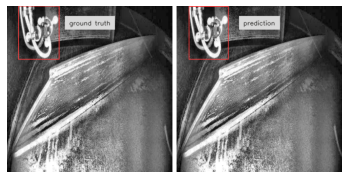

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


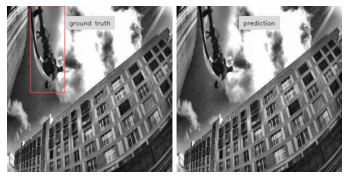

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


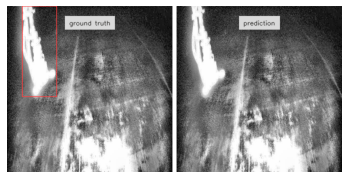

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


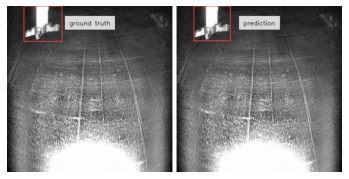

In [61]:
IMAGE_COUNT = 5

for i in range(IMAGE_COUNT):
    path, sourece_image, annotations = ds_test[i]

    image = Image.open(path)
    inputs = processor(image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)

    w, h = image.size
    results = processor.post_process_object_detection(
        outputs, target_sizes=[(h, w)], threshold=0.3)

    detections = sv.Detections.from_transformers(results[0]).with_nms(threshold=0.1)

    annotated_images = [
        annotate(sourece_image, annotations, ds_train.classes),
        annotate(sourece_image, detections, ds_train.classes)
    ]
    grid = sv.create_tiles(
        annotated_images,
        titles=['ground truth', 'prediction'],
        titles_scale=0.5,
        single_tile_size=(400, 400),
        tile_padding_color=sv.Color.WHITE,
        tile_margin_color=sv.Color.WHITE
    )
    sv.plot_image(grid, size=(6, 6))

